# Corporate Sector Clustering

## Introduction

INTRODUCTION OF THE PROJECT

In [3]:
# import
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.spatial import distance 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

# convert date 
from datetime import datetime

import matplotlib.pyplot as plt

In [4]:
# import data
corporate_pd = pd.read_csv("../corporate_rating.csv")
corporate_pd.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


INTRODUCE THE COLUMN NAMES

To perform PCA dimension reduction in order to visualize the data in 2D, we keep the numerical variables within the dataset.

In [5]:
corporate_np = corporate_pd.drop(['Rating','Name','Symbol','Rating Agency Name','Date','Sector'],axis = 1).to_numpy()
sectors = corporate_pd[['Sector']].to_numpy()
# # convert the date into date format
# for i in range(corporate_np.shape[0]):
#     corporate_np[i,2] = datetime.strptime(corporate_np[i,2], '%m/%d/%Y').date()
corporate_np.shape

(2029, 25)

In [6]:
# zero-center the data adapted from lab 5 code
def standardize(data):
    data_std = data.copy()
    
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)
    
    for i in range(data.shape[1]):
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]

    return data_std


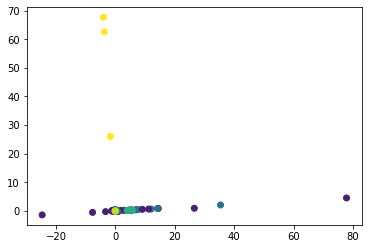

In [8]:
# standardize the data
corporate_std = standardize(corporate_np)

# visualize the data in 2D
pca = PCA(n_components=2)
corporate2D = pca.fit_transform(corporate_std)

sectorlist = list(corporate_pd.Sector.unique())
sector_num = sectors.copy()
for i in range(len(sectors)):
    sector_num[i] = sectorlist.index(sectors[i])

plt.scatter(corporate2D[:,0], corporate2D[:,1], c=sector_num)

The visualization of the original data is not so ideal given that there are extreme outliers within the data. Although most of the data are within 10 standard deviations from the mean, there are still some outliers that make it hard to see the number of clusters. Therefore we want to create an updated visualization without the outliers and more focused on the center cluster. Here we choose to keep data points that have -0.2 < x < 0.2  and y < 1.

In [9]:
# keep data points with x < 0.5
include = corporate2D[:,0]<0.5
corporate2Dnew = corporate2D[include]
sector_num1 = sector_num[include]

# keep data points with x > -0.5
include1 = corporate2Dnew[:,0]>-0.5
corporate2Dnew1 = corporate2Dnew[include1]
sector_num2 = sector_num1[include1]

# keep data points with y < 1
include2 = corporate2Dnew1[:,1]<1
corporate2Dnew2 = corporate2Dnew1[include2]
sector_num3 = sector_num2[include2]

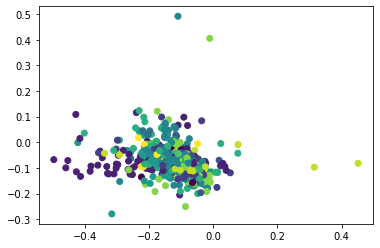

In [10]:
plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=sector_num3)

After zooming in towards the center, it seems that there are about 1-2 clusters within the data. However, the usual convention is to split the economy into [4 sectors](https://www.investopedia.com/ask/answers/05/industrysector.asp). 

- Primary Sector: This sector deals with the extraction and harvesting of natural resources such as agriculture and mining.
- Secondary Sector: This sector comprises construction, manufacturing, and processing. Basically, this sector comprises industries that relate to the production of finished goods from raw materials.
- Tertiary Sector: Retailers, entertainment, and financial companies make up this sector. These companies provide services to consumers.
- Quaternary Sector: The final sector deals with knowledge or intellectual pursuits including research and development (R&D), business, consulting services, and education.

We will implement k-means from scratch and explore the number of clusters.

## Self-implementation of k-means

In [11]:
def my_kmeans(array, cluster_num, rs):
    '''
    input: numpy array, cluster number k, random state
    return: the centers of the k clusters
    '''
    df = pd.DataFrame(array)
    
    # randomly assign initial centers
    centers = df.sample(cluster_num, random_state = rs).to_numpy()
    # set the number of max iterations
    max_it = 500
    
    for it in range(max_it):
        
        # label the datapoints to the nearest center
        dist = distance.cdist(array, centers)
        label = np.argmin(dist, axis = 1)
        
        # initialize the new centers
        new_center = np.ones((cluster_num, array.shape[1]))
        
        # for each cluster, calculate the average date point as the new center
        for i in range(cluster_num):
            cluster = array[label == i]
            new_center[i] = np.mean(cluster, axis = 0)
        
        # break if there is no change to the centers
        if (new_center == centers).all():
            break
        # update the centers
        else:
            centers = new_center

    return centers, label

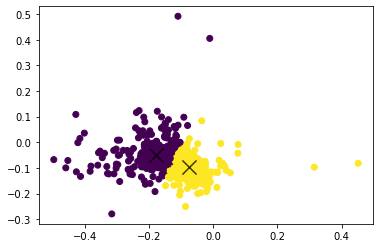

In [14]:
# visualize the datapoints with two clusters
centers2 = my_kmeans(corporate2Dnew2, 2, 1)[0]
label2 = my_kmeans(corporate2Dnew2, 2, 1)[1]

plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=label2)
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', marker="x", s=200, alpha=0.75)

The self-implemented k-means separated the blob of data points into two clusters. Although there seems to be an even separation in terms of the number of data points, there does not seem to be a clear boundary between the two clusters.

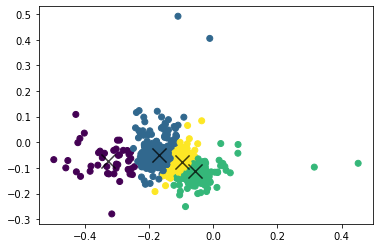

In [15]:
# visualize the datapoints with four clusters
centers4 = my_kmeans(corporate2Dnew2, 4, 1)[0]
label4 = my_kmeans(corporate2Dnew2, 4, 1)[1]

plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=label4)
plt.scatter(centers4[:, 0], centers4[:, 1], c='black', marker="x", s=200, alpha=0.75)

## Implementing k-means with sklearn

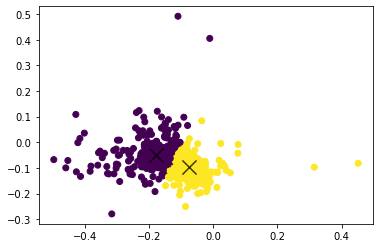

In [20]:
# k = 2

# set up the k-means algorithm
km_alg = KMeans(n_clusters=2, init="random",random_state = 1, max_iter = 200)

# fit the data
fit1 = km_alg.fit(corporate2Dnew2)
sklabels2 = fit1.labels_
skcenters2 = fit1.cluster_centers_

# plot the data
plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=sklabels2)
plt.scatter(skcenters2[:, 0], skcenters2[:, 1], c='black', marker="x", s=200, alpha=0.75)

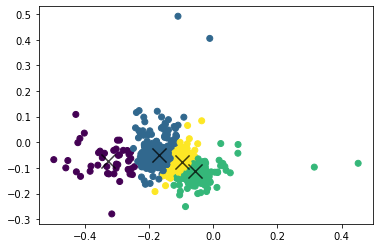

In [21]:
# k = 4

# set up the k-means algorithm
km_alg2 = KMeans(n_clusters=4, init="random",random_state = 1, max_iter = 200)

# fit the data
fit2 = km_alg2.fit(corporate2Dnew2)
sklabels4 = fit2.labels_
skcenters4 = fit2.cluster_centers_

# plot the data
plt.scatter(corporate2Dnew2[:,0], corporate2Dnew2[:,1], c=sklabels4)
plt.scatter(skcenters4[:, 0], skcenters4[:, 1], c='black', marker="x", s=200, alpha=0.75)

## Self-implementation v.s. sklearn

## The optimal number of clusters using elbowology

## Cluters and discussions

## Spectural Clustering